# Using Genestack Omics APIs to query single-cell data

This notebook demonstrates the scalability of the Omics APIs in querying and getting thousands of single-cell samples and expression values.

The dataset used is [GSE120575](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE120575), from Sade-Feldman et al., ["Defining T Cell States Associated with Response to Checkpoint Immunotherapy in Melanoma"](https://www.ncbi.nlm.nih.gov/pubmed/30388456), 2018. It has **16,291 individual immune cells from 48 tumor samples** of melanoma patients treated with checkpoint inhibitors.

Example queries are provided to get:
- A subset of samples that correspond to CD8+ cells (**8,331 samples**)
- The expression values of the gene TCF7 across CD8+ cells

Three plots are produced:
- The expression distribution of TCF7 across CD8+ cells
- The expression distribution of TCF7 across CD8+ cells, grouped by cluster and patient response
- The association of patient response with TCF7 expression among CD8+ cells

### Set instance and token

In [1]:
library(integrationCurator)
suppressMessages(library(tidyverse))

Sys.setenv(PRED_SPOT_HOST = 'inc-dev.genestack.com', PRED_SPOT_TOKEN = '<token>')
page_limit = 20000

### Get a subset of samples that correspond to CD8+ cells

In [2]:
study_filter = sprintf('"%s"="%s"', 'Study Title', 'Copy 162d3-j7d0g-ntesvl74f8jgx1y')
cell_filter = paste(sprintf('"Cluster number"="%s"', c(5, 8, 10, 9, 11)), collapse=" OR ")

start = Sys.time()
samples <- as_tibble(integrationCurator::OmicsQueriesApi_search_samples(
    study_filter=study_filter,
    sample_filter=cell_filter,
    page_limit=page_limit
)$content$data[['metadata']])

cat(sprintf('Time to get %s samples: %s seconds\n\n', nrow(samples), round(Sys.time()-start)))
print(samples)

Time to get 8331 samples: 18 seconds

# A tibble: 8,331 x 38
   `genestack:acce… `Arvados URL` `Sample Source … `Sample Source`
   <chr>            <chr>         <chr>            <chr>          
 1 GSF1042493       https://arva… A4_P7_M36_L001   National Insti…
 2 GSF1042492       https://arva… A4_P6_M36_L001   National Insti…
 3 GSF1042491       https://arva… A3_P9_M36_L001   National Insti…
 4 GSF1042490       https://arva… A3_P8_M36_L001   National Insti…
 5 GSF1042496       https://arva… A5_P6_M36_L001   National Insti…
 6 GSF1042495       https://arva… A4_P9_M36_L001   National Insti…
 7 GSF1042494       https://arva… A4_P8_M36_L001   National Insti…
 8 GSF1042485       https://arva… A12_P8_M36_L001  National Insti…
 9 GSF1042484       https://arva… A12_P7_M36_L001  National Insti…
10 GSF1042483       https://arva… A12_P6_M36_L001  National Insti…
# … with 8,321 more rows, and 34 more variables: `Species or Strain` <chr>,
#   Sex <chr>, Disease <chr>, `Donor Treatment/Treatment Na

### Get the expression values of the gene TCF7 across CD8+ cells

In [3]:
gene = 'TCF7'
expression_filter = sprintf('Gene=%s MinValue=0', gene)

start = Sys.time()
expressions = as_tibble(do.call(cbind, OmicsQueriesApi_search_expression_data(
    study_filter = study_filter,
    sample_filter = cell_filter,
    ex_query = expression_filter,
    page_limit = page_limit
)$content$data))

cat(sprintf('Time to get %s expression values: %s seconds\n\n', 
    nrow(expressions), round(Sys.time()-start)))
print(expressions)

Time to get 8331 expression values: 24 seconds

# A tibble: 8,331 x 6
   itemId   metadata.Scale `metadata.Arvados URL`        gene  expression sample
   <fct>    <chr>          <chr>                         <fct>      <dbl> <chr> 
 1 GSF1056… dkdskjds       https://arvados.inc-dev.gene… TCF7        3.23 GSF10…
 2 GSF1056… dkdskjds       https://arvados.inc-dev.gene… TCF7        0    GSF10…
 3 GSF1056… dkdskjds       https://arvados.inc-dev.gene… TCF7        0    GSF10…
 4 GSF1056… dkdskjds       https://arvados.inc-dev.gene… TCF7        0    GSF10…
 5 GSF1056… dkdskjds       https://arvados.inc-dev.gene… TCF7        0    GSF10…
 6 GSF1056… dkdskjds       https://arvados.inc-dev.gene… TCF7        0    GSF10…
 7 GSF1056… dkdskjds       https://arvados.inc-dev.gene… TCF7        6.88 GSF10…
 8 GSF1056… dkdskjds       https://arvados.inc-dev.gene… TCF7        0    GSF10…
 9 GSF1056… dkdskjds       https://arvados.inc-dev.gene… TCF7        0    GSF10…
10 GSF1056… dkdskjds       https://arva

### Expression distribution of TCF7 across CD8+ cells

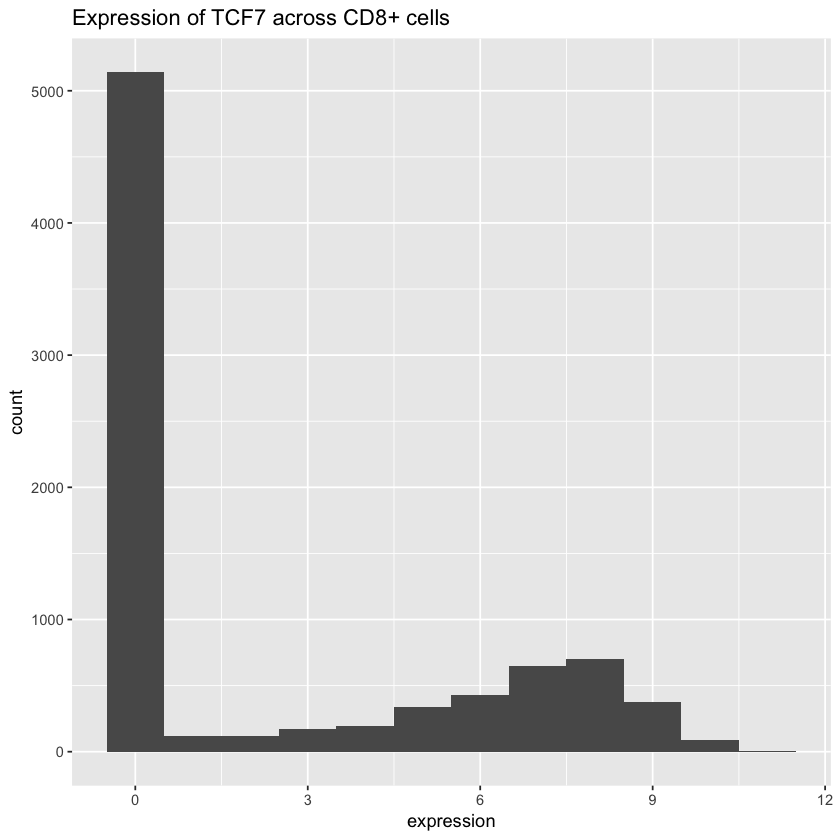

In [4]:
ggplot(expressions, aes(x=expression)) + 
    geom_histogram(binwidth = 1) + 
    ggtitle(sprintf('Expression of %s across CD8+ cells', gene))

### Distribution of TCF7 expression across CD8+ cells, grouped by cluster and patient response

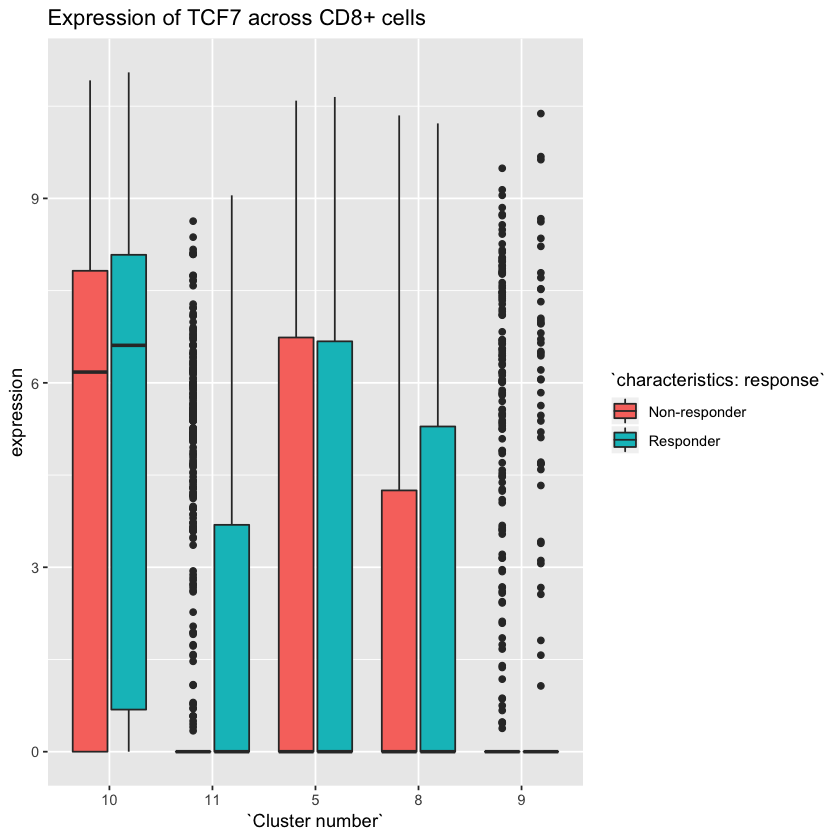

In [5]:
samples_expressions = inner_join(samples, expressions, by=c("genestack:accession"="sample"))
ggplot(samples_expressions, 
    mapping=aes(x=`Cluster number`, y=expression, fill=`characteristics: response`)) + 
    geom_boxplot() + ggtitle(sprintf('Expression of %s across CD8+ cells', gene))

### Association of patient response with TCF7 expression among CD8+ cells

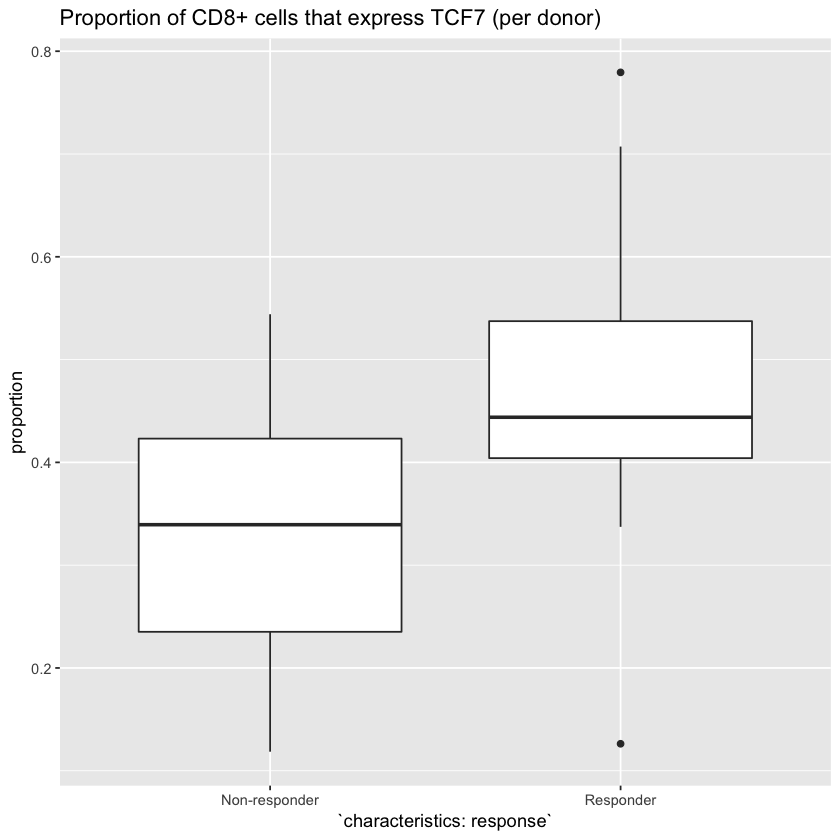

In [6]:
expression_threshold = 2
samples_expressions = samples_expressions %>% 
    mutate(expressed = ifelse(expression > expression_threshold, 1, 0))
samples_expressions = samples_expressions %>% 
    group_by(`Donor ID`, `characteristics: response`) %>% 
    summarise(proportion = mean(expressed))
ggplot(samples_expressions, mapping=aes(x=`characteristics: response`, y=proportion)) + 
    geom_boxplot() + ggtitle(sprintf('Proportion of CD8+ cells that express %s (per donor)', gene))